In [29]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from lib import full_flow_dataloader

# from config import logger
from lib.norms import Norm1Scaler, Norm3Scaler

train_processed, test_processed = full_flow_dataloader.load_full_flow_data()

In [30]:
train_processed.shape

(1538, 6154)

In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import mlflow.pytorch

class RegressionNet(nn.Module):
    def __init__(self):
        super(RegressionNet, self).__init__()
        # Define layers
        self.fc1 = nn.Linear(6144, 1024) # First layer
        self.dropout1 = nn.Dropout(0.3)  # Dropout for regularization
        self.fc2 = nn.Linear(1024, 512)  # Second layer
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(512, 256)   # Third layer
        self.fc4 = nn.Linear(256, 128)   # Fourth layer
        self.fc5 = nn.Linear(128, 8)     # Output layer with 8 variables

    def forward(self, x):
        # Forward pass
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x) # No activation, linear output
        return x

# Initialize the model
model = RegressionNet()

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Model summary
print(model)

RegressionNet(
  (fc1): Linear(in_features=6144, out_features=1024, bias=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=128, bias=True)
  (fc5): Linear(in_features=128, out_features=8, bias=True)
)


In [32]:
from lib.reproduction import major_oxides

In [33]:
train_processed.head()

,240.811,240.86501,240.918,240.972,241.02699,241.07899,241.133,241.188,241.24001,241.29401,...,SiO2,TiO2,Al2O3,FeOT,MgO,CaO,Na2O,K2O,Sample Name,ID
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,79.35,0.3,9.95,2.18,1.0,1.2,2.75,1.84,201426,201426_2013_11_06_161336_ccs
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,79.35,0.3,9.95,2.18,1.0,1.2,2.75,1.84,201426,201426_2013_11_06_161134_ccs
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,79.35,0.3,9.95,2.18,1.0,1.2,2.75,1.84,201426,201426_2013_11_06_162544_ccs
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,79.35,0.3,9.95,2.18,1.0,1.2,2.75,1.84,201426,201426_2013_11_06_161514_ccs
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,79.35,0.3,9.95,2.18,1.0,1.2,2.75,1.84,201426,201426_2013_11_06_160941_ccs


In [34]:
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = None
        self.epochs_no_improve = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.epochs_no_improve = 0
        else:
            self.epochs_no_improve += 1
            if self.epochs_no_improve >= self.patience:
                self.early_stop = True

In [35]:
from sklearn.model_selection import train_test_split
from lib.utils import custom_train_test_split

train_cols = train_processed.columns
test_cols = test_processed.columns
norm = 3

scaler = (
    Norm1Scaler()
    if norm == 1
    else 
    Norm3Scaler()
)

train = scaler.fit_transform(train_processed)
test = scaler.fit_transform(test_processed)

# turn back into dataframe
train = pd.DataFrame(train, columns=train_cols)
test = pd.DataFrame(test, columns=test_cols)

split_train, split_val = custom_train_test_split(train, "Sample Name", test_size=0.2, random_state=42)

drop_cols = major_oxides + ["ID", "Sample Name"]

X_train = split_train.drop(columns=drop_cols).to_numpy()
y_train = split_train[major_oxides].to_numpy()
X_val = split_val.drop(columns=drop_cols).to_numpy()
y_val = split_val[major_oxides].to_numpy()

## SPLIT CONVENTIONAL
# Splitting the training data into training and validation sets
# X = train.drop(columns=drop_cols).to_numpy()
# y = train[major_oxides].to_numpy()

# Split ratio: 80% train, 20% validation
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Converting test set
X_test = test.drop(columns=drop_cols).to_numpy()
y_test = test[major_oxides].to_numpy()

# Convert to tensors
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()
X_val = torch.from_numpy(X_val).float()
y_val = torch.from_numpy(y_val).float()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

In [36]:
# Train the model
from datetime import datetime
num_epochs = 10000
batch_size = 32
losses = []
val_losses = []

early_stopping = EarlyStopping(patience=300, min_delta=0.01)

mlflow.set_experiment(f'ANN_Norm{norm}_{datetime.now().strftime("%Y%m%d-%H%M%S")}')

# Start an MLFlow run
mlflow.start_run()

# Log hyperparameters
mlflow.log_param("num_epochs", num_epochs)
mlflow.log_param("batch_size", batch_size)
# ... log other hyperparameters as needed

for epoch in range(num_epochs):
    # Training
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val)
        val_loss = criterion(val_outputs, y_val)
        val_losses.append(val_loss.item())

    # Log metrics for each epoch
    mlflow.log_metric('loss', loss.item(), step=epoch)
    mlflow.log_metric('val_loss', val_loss.item(), step=epoch)

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')

    # Early stopping logic
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Early stopping triggered")
        mlflow.log_metric('early_stopping_epoch', epoch, step=epoch)
        break

# Log the model at the end of training
mlflow.pytorch.log_model(model, "model")

2024/01/25 17:01:55 INFO mlflow.tracking.fluent: Experiment with name 'ANN_Norm3_20240125-170154' does not exist. Creating a new experiment.


Epoch [10/10000], Loss: 474.0053, Val Loss: 457.3297
Epoch [20/10000], Loss: 292.2853, Val Loss: 248.9938
Epoch [30/10000], Loss: 66.2153, Val Loss: 66.5760
Epoch [40/10000], Loss: 61.7840, Val Loss: 69.8723
Epoch [50/10000], Loss: 42.2952, Val Loss: 49.6163
Epoch [60/10000], Loss: 38.9366, Val Loss: 45.9291
Epoch [70/10000], Loss: 36.2156, Val Loss: 41.6033
Epoch [80/10000], Loss: 34.6025, Val Loss: 38.7090
Epoch [90/10000], Loss: 33.6462, Val Loss: 37.0863
Epoch [100/10000], Loss: 32.5722, Val Loss: 36.1390
Epoch [110/10000], Loss: 32.5442, Val Loss: 35.5118
Epoch [120/10000], Loss: 31.7515, Val Loss: 35.1413
Epoch [130/10000], Loss: 31.4900, Val Loss: 34.9012
Epoch [140/10000], Loss: 31.2236, Val Loss: 34.7293
Epoch [150/10000], Loss: 30.8069, Val Loss: 34.5760
Epoch [160/10000], Loss: 30.6248, Val Loss: 34.4076
Epoch [170/10000], Loss: 30.5922, Val Loss: 34.2415
Epoch [180/10000], Loss: 30.2788, Val Loss: 34.0715
Epoch [190/10000], Loss: 29.9894, Val Loss: 33.8951
Epoch [200/10000]

/home/christian/projects/p9/baseline/venv/lib/python3.10/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/home/christian/projects/p9/baseline/venv/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


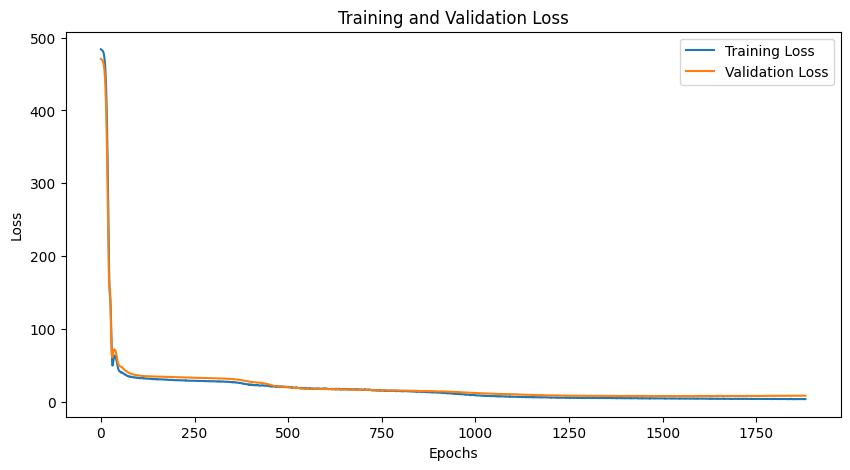

Loss: 6.5891


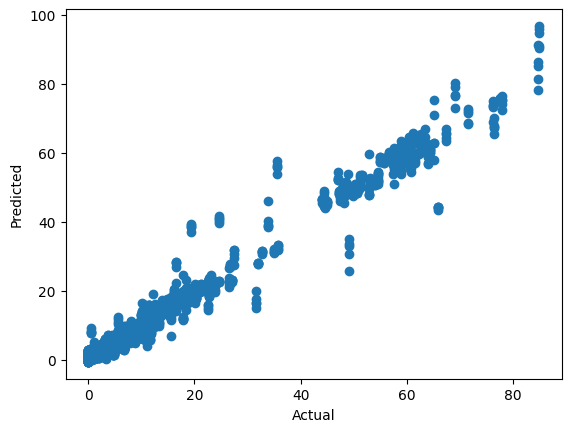

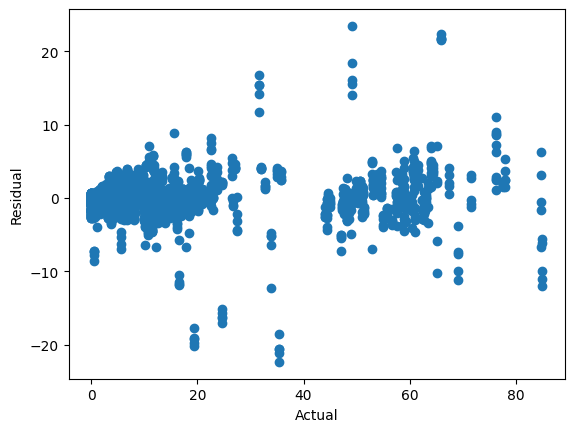

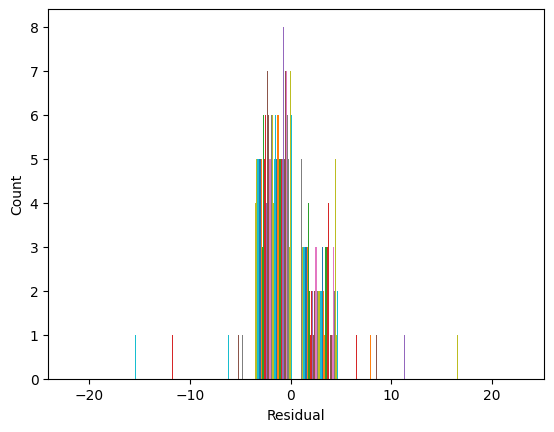

In [37]:
# Plot the loss curve
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Test the model
with torch.no_grad():
    outputs = model(X_test)
    loss = criterion(outputs, y_test)
    print(f'Loss: {loss:.4f}')
    
    # Plot predictions vs actual
    plt.scatter(y_test, outputs)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.show()
    
    # Plot the residuals
    plt.scatter(y_test, y_test-outputs)
    plt.xlabel('Actual')
    plt.ylabel('Residual')
    plt.show()
    
    # Plot the residuals histogram
    plt.hist(y_test-outputs)
    plt.xlabel('Residual')
    plt.ylabel('Count')
    plt.show()

In [38]:
# calculate RMSEs
rmse = np.sqrt(mean_squared_error(y_test, outputs))
print("RMSE: ", rmse)
mlflow.log_metric('rmse', float(rmse))

RMSE:  2.566926


In [39]:
# rmse for each oxide
rmse_oxides = np.sqrt(mean_squared_error(y_true=y_test, y_pred=outputs, multioutput="raw_values"))
# as dataframe
rmse_oxides = pd.DataFrame(rmse_oxides, index=major_oxides, columns=["RMSE"])

# log as metrics for each major oxide
for oxide, rmse in rmse_oxides.iterrows():
    mlflow.log_metric(f"rmse_{oxide}", rmse[0])

/tmp/ipykernel_28487/936945190.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mlflow.log_metric(f"rmse_{oxide}", rmse[0])


In [40]:
rmse_oxides

,RMSE
SiO2,4.877448
TiO2,0.623302
Al2O3,2.213526
FeOT,4.141255
MgO,1.675146
CaO,1.319609
Na2O,1.052954
K2O,0.910485


In [41]:
paper=5.3+1.03+3.47+2.31+2.21+2.72+0.62+0.82
this=rmse_oxides.sum()

(paper/8), round((sum(this)/8), 2)

(2.31, 2.1)

In [42]:
mlflow.end_run()